In [4]:
import numpy as np
import matplotlib.pyplot as plt
import guide_onde as go
import scipy.signal as sig

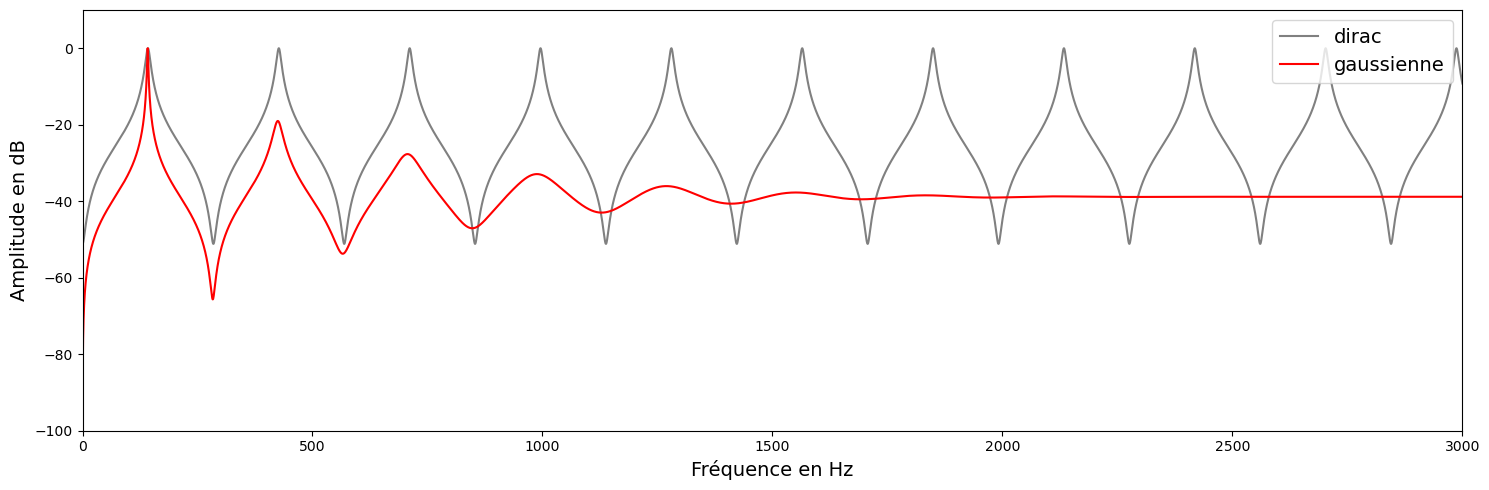

In [16]:
fe = 44100

t_max = 1

Nsim = int(t_max*fe)

Nfft = 4*Nsim

L = 60e-2
r = 1e-2
S = np.pi*r**2
rho = 1.292
c = 340
Zc = rho*c/S

T = go.retardT(L,c)

pertes_dirac=0.9
frac_T=10
rate_gauss=0.08

gamma = 0.4
zeta = 0.2

freq = np.fft.rfftfreq(Nfft,1/fe)

dirac = go.reflexion(T=T,pertes_dirac=pertes_dirac,frac_T=frac_T,rate_gauss=rate_gauss,fe=fe, Nsim=Nsim,type='dirac')

a = 1.5e-2
Zth = 0.25*(2*np.pi*freq*a/c)**2 + 1j*0.6133*2*np.pi*freq*a/c

Rdirac = np.fft.rfft(dirac,n=Nfft)
Zdirac = (1+Rdirac)/(1-Rdirac+1e-8)

gaussian = go.reflexion(T=T,pertes_dirac=pertes_dirac,frac_T=frac_T,rate_gauss=rate_gauss,fe=fe, Nsim=Nsim,type='gauss')
Rgauss = np.fft.rfft(gaussian,n=Nfft)
Zgauss = (1+Rgauss)/(1-Rgauss+1e-8)

triangle = go.reflexion(T=T,pertes_dirac=pertes_dirac,frac_T=frac_T,rate_gauss=rate_gauss,fe=fe, Nsim=Nsim,type='triangle')
Rtri = np.fft.rfft(triangle,n=Nfft)
Ztri = (1+Rtri)/(1-Rtri+1e-8)

mod_dirac = 20*np.log10(abs(Zdirac)/np.max(abs(Zdirac))+ 1e-12)
mod_tri = 20*np.log10(abs(Ztri)/np.max(abs(Ztri)) + 1e-12)
mod_gauss = 20*np.log10(abs(Zgauss)/np.max(abs(Zgauss)) + 1e-12)

plt.figure(figsize=(15,5))
#plt.plot(freq, 10*np.log10(abs(Zth)/np.max(Zth)+1e-12))
plt.plot(freq, mod_dirac,color='grey',label='dirac')
#plt.plot(freq, mod_tri,color='b',label='triangle')
plt.plot(freq, mod_gauss,color='r',label='gaussienne')
plt.legend(fontsize=14, loc='upper right')
plt.xlabel("Fréquence en Hz",size=14)
plt.ylabel("Amplitude en dB",size=14)

plt.ylim(-100,10)
plt.xlim(0,3000)

plt.tight_layout()

#plt.savefig("figures/impedance_entree_reflexion.pdf", transparent=True,bbox_inches = "tight")

In [17]:
def transfert(Zs):
    '''Calcule l'impédance ramenée à l'entrée Ze du tube de longueur L, 
    à partir du rapport Zs (mesuré par le capteur)'''

    omega = freq*2*np.pi
    
    k = omega/c
    Zc = 1 #rho*c/S

    # sans amortissement

    Ze = Zc*np.tanh(1j*k*L+np.arctanh(Zs/Zc))

    return Ze

In [18]:
N = Nsim//5

pdirac, udirac = go.clarinette(t_max = t_max, sample_rate = fe, gamma = gamma, zeta = zeta, type_reflection='dirac',
                               l=L, c0=c,pertes_dirac=pertes_dirac,frac_T=frac_T,rate_gauss=rate_gauss)
Z_d_sim = np.fft.rfft(pdirac/(Zc*udirac + 1e-20),Nfft)
#Z_d_sim = np.fft.rfft(pdirac,Nfft)
freq_w, Welch_d = sig.welch(pdirac/(Zc*udirac + 1e-20), fs = fe, window = 'hann', nperseg = N, nfft = Nfft, noverlap= int(0.25*N)) 

ptri, utri = go.clarinette(t_max = t_max, sample_rate = fe, gamma = gamma, zeta = zeta, type_reflection='triangle',
                               l=L, c0=c,pertes_dirac=pertes_dirac,frac_T=frac_T,rate_gauss=rate_gauss)
Z_t_sim = np.fft.rfft(ptri/(Zc*utri + 1e-20),Nfft)
#Z_t_sim = np.fft.rfft(ptri,Nfft)
freq_w, Welch_t = sig.welch(ptri/(Zc*utri + 1e-20), fs = fe, window = 'hann', nperseg = N, nfft = Nfft, noverlap= int(0.25*N)) 

pgauss, ugauss = go.clarinette(t_max = t_max, sample_rate = fe, gamma = gamma, zeta = zeta, type_reflection='gauss',
                               l=L, c0=c,pertes_dirac=pertes_dirac,frac_T=frac_T,rate_gauss=rate_gauss)
Z_g_sim = np.fft.rfft(pgauss/(Zc*ugauss + 1e-20),Nfft)
#Z_g_sim = np.fft.rfft(pgauss,Nfft)
freq_w, Welch_g = sig.welch(pgauss/(Zc*ugauss + 1e-20), fs = fe, window = 'hann', nperseg = N, nfft = Nfft, noverlap= int(0.25*N)) 

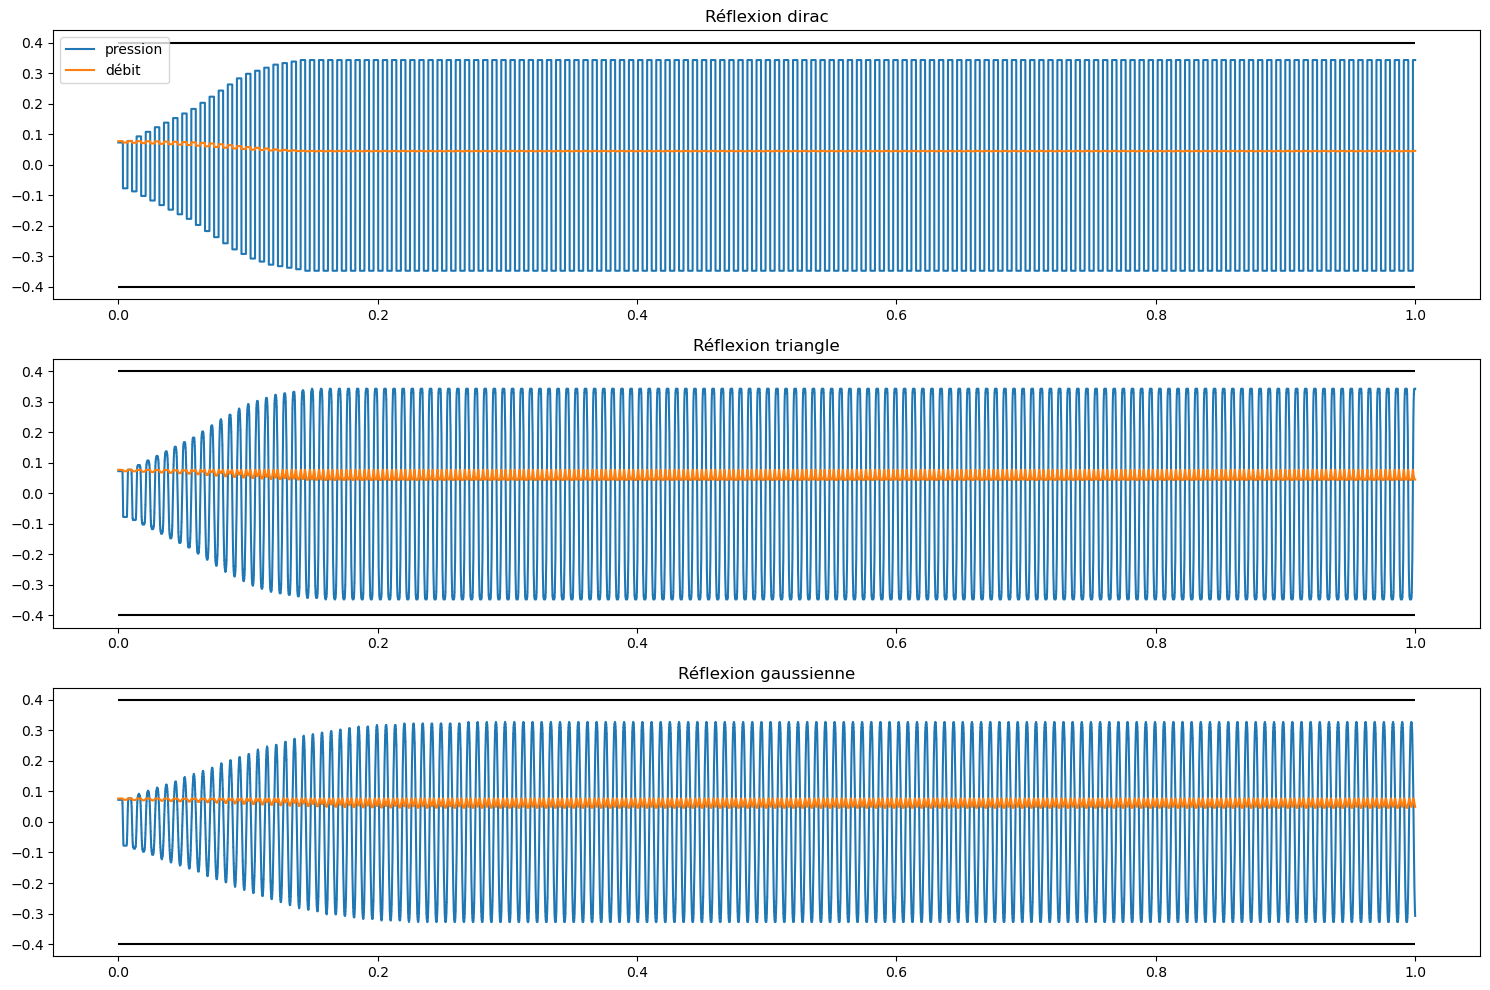

In [19]:
fig, ax = plt.subplots(3,1,figsize=(15,10))

tps = np.arange(int(t_max*fe))/fe
ax[0].plot(tps,pdirac,label = 'pression')
ax[0].plot(tps,udirac,label = 'débit')
ax[0].hlines(gamma,tps[0],tps[-1],'k')
ax[0].hlines(-gamma,tps[0],tps[-1],'k')
#ax[0].set_xlim(0.25,0.40)
ax[0].legend()
ax[0].set_title("Réflexion dirac")
ax[1].plot(tps,ptri)
ax[1].plot(tps,utri)
ax[1].hlines(gamma,tps[0],tps[-1],'k')
ax[1].hlines(-gamma,tps[0],tps[-1],'k')
ax[1].set_title("Réflexion triangle")
#ax[1].set_xlim(0.25,0.40)
ax[2].plot(tps,pgauss)
ax[2].plot(tps,ugauss)
ax[2].hlines(gamma,tps[0],tps[-1],'k')
ax[2].hlines(-gamma,tps[0],tps[-1],'k')
ax[2].set_title("Réflexion gaussienne")
#ax[2].set_xlim(0.25,0.40)
#plt.xlim(0,10000)

plt.tight_layout()

#plt.savefig("figure/pression_debit.pdf", transparent=True,bbox_inches = "tight")

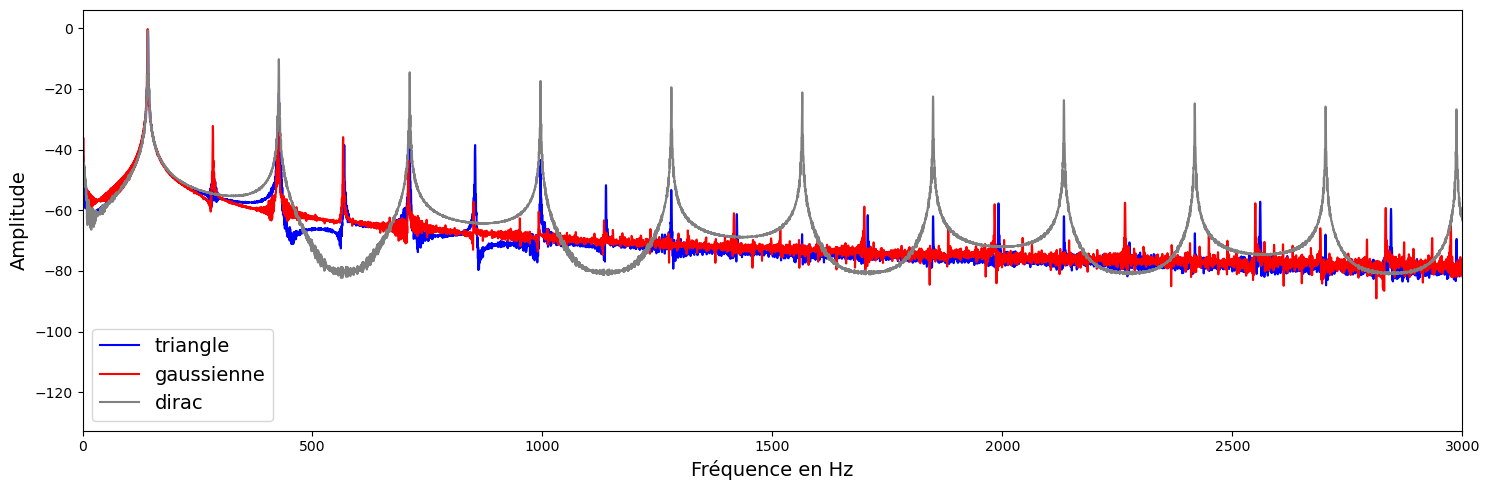

In [20]:
plt.figure(figsize=(15,5))

plt.plot(freq, sig.medfilt(20*np.log10(abs(Z_t_sim)/np.max(abs(Z_t_sim))+1e-8),3),alpha = 1, color='b',label='triangle')
plt.plot(freq, sig.medfilt(20*np.log10(abs(Z_g_sim)/np.max(abs(Z_g_sim))+1e-8),3),alpha = 1, color='r',label='gaussienne')
plt.plot(freq, sig.medfilt(20*np.log10(abs(Z_d_sim)/np.max(abs(Z_d_sim))+1e-8),3),alpha = 1, color='grey',label='dirac')

#plt.plot(freq_w, 20*np.log10(abs(Welch_t)/np.max(abs(Welch_t))),color='b',label='triangle')
#plt.plot(freq_w, 20*np.log10(abs(Welch_g)/np.max(abs(Welch_g))),color='r',label='gaussienne')
#plt.plot(freq_w, 20*np.log10(abs(Welch_d)/np.max(abs(Welch_d))),color='grey',label='dirac')

plt.xlabel("Fréquence en Hz",size=14)
plt.ylabel("Amplitude",size=14)
plt.legend(fontsize=14)

#plt.ylim(-100,10)
plt.xlim(0,3000)

plt.tight_layout()

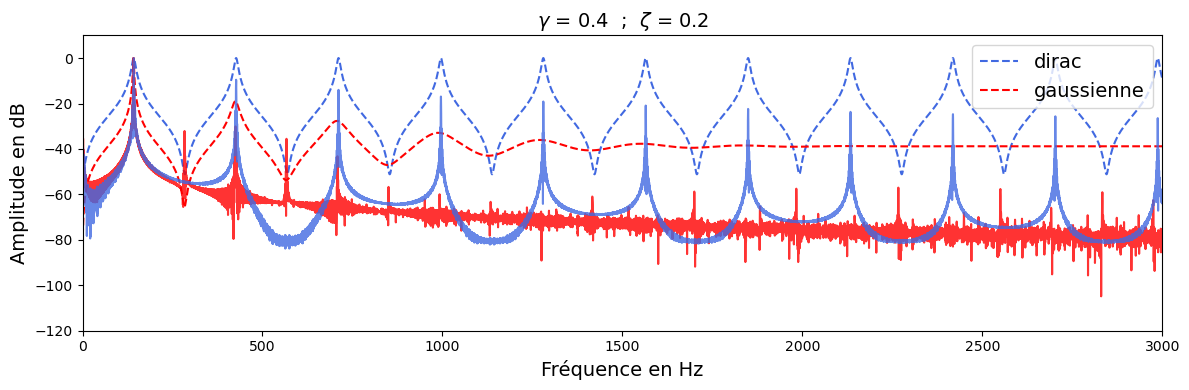

In [23]:
plt.figure(figsize=(12,4))

#plt.plot(freq, 20*np.log10(abs(Ze_th)/np.max(Ze_th)+1e-12))
plt.plot(freq, 20*np.log10(abs(Zdirac)/np.max(abs(Zdirac))+1e-12),color='royalblue',linestyle="--",label='dirac')
#plt.plot(freq, 20*np.log10(abs(Ztri)/np.max(abs(Ztri))+1e-12),color='b',linestyle="--",label='triangle')
plt.plot(freq, 20*np.log10(abs(Zgauss)/np.max(abs(Zgauss))+1e-12),color='r',linestyle="--",label='gaussienne')

#plt.plot(freq, 20*np.log10(abs(Z_t_sim)/np.max(abs(Z_t_sim))+1e-8),color='b',alpha = 0.8)
plt.plot(freq, 20*np.log10(abs(Z_g_sim)/np.max(abs(Z_g_sim))+1e-8),color='r',alpha = 0.8)
plt.plot(freq, 20*np.log10(abs(Z_d_sim)/np.max(abs(Z_d_sim))+1e-8),color='royalblue',alpha = 0.8)

plt.legend(fontsize=14, loc='upper right')
plt.xlabel("Fréquence en Hz",size=14)
plt.ylabel("Amplitude en dB",size=14)

plt.ylim(-120,10)
plt.xlim(0,3000)

plt.title(r"$\gamma$ = "+str(gamma)+r"  ;  $\zeta$ = "+str(zeta),size=14)

plt.tight_layout()

plt.savefig("figures/impedance_entree_simulation.pdf", transparent=True,bbox_inches = "tight")